In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models,datasets,transforms
from matplotlib import pyplot as plt
import time 
import os
import copy

plt.ion()

In [0]:
data_transforms={
    'train':transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),

    'val':transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

In [9]:
import zipfile
!wget --no-check-certificate \
    "https://download.pytorch.org/tutorial/hymenoptera_data.zip" \
    -O "/tmp/hymenoptera_data.zip"

local_zip = '/tmp/hymenoptera_data.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-01-05 12:47:34--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.29.19, 13.224.29.73, 13.224.29.48, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.29.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘/tmp/hymenoptera_data.zip’

/tmp/hymenoptera_da 100%[===================>]  45.10M  43.4MB/s    in 1.0s    

2020-01-05 12:47:36 (43.4 MB/s) - ‘/tmp/hymenoptera_data.zip’ saved [47286322/47286322]



In [0]:
data_dir="../tmp/hymenoptera_data/"
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
for x in ['train','val']
}
data_loaders={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
              shuffle=True,num_workers=4) for x in ['train','val']}

dataset_sizes={x: len(image_datasets[x]) for x in ['train','val']}
class_names=image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

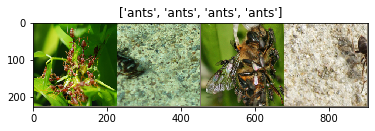

In [25]:
def imshow(inp,title=None):
  inp=inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

input,classes=next(iter(data_loaders['train']))
out=torchvision.utils.make_grid(input)
imshow(out,title=[class_names[0] for i in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [28]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6764 Acc: 0.6926
val Loss: 0.2582 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4417 Acc: 0.8197
val Loss: 0.2322 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.5378 Acc: 0.7623
val Loss: 0.2871 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4588 Acc: 0.8238
val Loss: 0.4945 Acc: 0.8105

Epoch 4/24
----------
train Loss: 0.4403 Acc: 0.8279
val Loss: 0.2277 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.3603 Acc: 0.8279
val Loss: 0.1696 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.2949 Acc: 0.8689
val Loss: 0.1718 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3077 Acc: 0.8484
val Loss: 0.1774 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3284 Acc: 0.8402
val Loss: 0.2190 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3173 Acc: 0.8361
val Loss: 0.1838 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2849 Acc: 0.8730
val Loss: 0.1864 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2460 Acc: 0.9098
val Loss: 0.1913 Acc: 0.9346

Ep

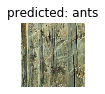

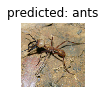

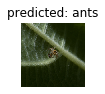

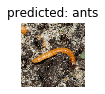

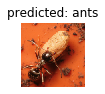

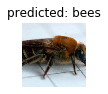

In [37]:
visualize_model(model_ft)
plt.ioff()
plt.show()